This notebook is for running in Google Colab. It has all the classes and methods together for convenience.
To run this notebook, simply upload the following files to the session storage:
- trainX.npy
- trainy.npy

In [ ]:
! pip install tensorflow wandb numpy

### Setup

In [2]:
import wandb
import random
import numpy as np
import keras.backend as K
import tensorflow as tf
from os import environ
import matplotlib.pyplot as plt

# Set random seeds
environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash('setting random seeds') % 2 ** 32 - 1)
np.random.seed(hash('improves reproducibility') % 2 ** 32 - 1)
tf.random.set_seed(hash('so that runs are repeatable'))

print("# GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')):
    print('GPU Device Name', tf.test.gpu_device_name())

LABELS = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# GPUs Available:  1
GPU Device Name /device:GPU:0


### Sweep Configs

In [3]:
from typing import Dict, Any

sweep_config: Dict[str, Any] = {
    'name': '',
    'method': 'grid',
    'metric': {
        'goal': 'minimize', 
        'name': 'loss'
    },
    'parameters': {
        'optimizer': { 'values': ['adam', 'sgd'] },
        'epochs': { 'value': 20 },
        'learning_rate': {
            'values': [0.001, 0.0002, 0.0001]
        },
        'fc1_size': {
            'values': [32, 64, 128],
        },
        'fc2_size': {
            'values': [32, 64, 128],
        },
    }
}

### Model Utils

In [4]:
import wandb
import tensorflow as tf
from wandb.keras import WandbCallback

class ModelUtils:
    '''
    Utility methods for model training, 
    validation, testing and selection.
    '''
    def __init__(self, training_data, validation_data, batch_size):
        self.training_data = training_data
        self.validation_data = validation_data
        self.batch_size = batch_size

    def build_optimizer(self, optimizer: str = 'adam', lr: float = 0.01, momentum: float = 0.0):
        if optimizer == 'adam':
            return tf.keras.optimizers.Adam(learning_rate=lr)
        else:
            return tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

    def train(self):
        '''
        This method trains self.model. 
        Performs validation in an embedded manner.
        :param x: training data
        :param y: training labels
        '''
        config_defaults = {
            'epochs': 20,
            'learning_rate': 0.001,
            'optimizer': 'adam',
        }
        wandb.init(project='intel-icc', entity='manelfideles', config=config_defaults)
        config = wandb.config

        base_model = tf.keras.applications.ResNet50(
            include_top=False,
            input_shape=(50, 50, 3),
            weights='imagenet',
            pooling='max'
        )
        base_model.trainable = False
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.Dense(config.fc1_size, activation='relu'),
            tf.keras.layers.Dense(config.fc2_size, activation='relu'),
            tf.keras.layers.Dense(6, activation='softmax'),
        ])
        optimizer = self.build_optimizer(config.optimizer, config.learning_rate, 0.9)
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False)
        metrics = ['Accuracy', 'AUC', 'Precision', 'Recall']
        model.compile(optimizer, loss=loss, metrics=metrics)
        model.summary()
        model.fit(
            self.training_data,
            validation_data=self.validation_data,
            epochs=config.epochs, 
            batch_size=self.batch_size,
            callbacks=[WandbCallback()]
        )
        wandb.finish()

### Data Utils

In [10]:
import numpy as np
from PIL import Image as im
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

class DataUtils:
    '''
    Utility methods for importing and exporting data, as well
    as for simple pre-processing.
    '''
    def __init__(self, input_dir_path: str, output_dir_path: str, batch_size: int = 512):
        self.input_dir_path = input_dir_path
        self.output_dir_path = output_dir_path
        self.batch_size = batch_size

    def load_npy(self, filename: str) -> np.array:
        return np.load(
            self.input_dir_path + f'/{filename}.npy',
            allow_pickle=True
        )

    def tvt_split(self, x, y, test_size: float = 0.3):
        x_train, x_test, y_train, y_test = train_test_split(
            x, y,
            test_size=test_size, 
            random_state=1
        )
        return x_train, x_test, y_train, y_test

    def make_image_generator(self, train: bool = True):
      return ImageDataGenerator(
          preprocessing_function=tf.keras.applications.resnet.preprocess_input,
          rotation_range = 40,
          width_shift_range = 0.3,
          height_shift_range = 0.3,
          horizontal_flip = True,
      )
    
    def load_data(self, train: bool):
        if train:
            x, y = self.load_npy('trainX'), to_categorical(self.load_npy('trainy'))
            x_train, x_val, y_train, y_val = self.tvt_split(x, y)
            train_datagen = self.make_image_generator()
            train_datagen.fit(x_train)
            std_datagen = ImageDataGenerator(
                preprocessing_function=train_datagen.standardize
            )
            train_data = train_datagen.flow(
                x_train,
                y_train,
                batch_size=self.batch_size,
            )
            val_data = std_datagen.flow(x_val, y_val, batch_size=self.batch_size)
            return (train_data, val_data)
        else:
            return None

    def save_model(self, filename: str):
        raise NotImplementedError   

    def display_image(self, array: np.array) -> im.Image: 
        return im.fromarray(array)
    
    def _normalize(self, array: np.array) -> np.array:
        return (array / 255)
    
    def _standardize(self, array: np.array) -> np.array:
        mean, std = np.mean(
            array, 
            axis=(1,2), 
            keepdims=True
        ), np.std(
            array,
            axis=(1,2), 
            keepdims=True
        )
        return ((array - mean) / std)

### Main

In [ ]:
# Import data
with tf.device('/device:GPU:0'):
  data_utils = DataUtils('.', './outputs')
  train_data, val_data = data_utils.load_data(train = True)

  model_utils = ModelUtils(
      training_data=train_data,
      validation_data=val_data,
      batch_size=512,
  )

  # Run sweeps and log results
  wandb.login()
  sweep_config['name'] = 'optimizing+ResNetV50-3'
  sweep_id = wandb.sweep(sweep_config, entity='manelfideles', project="intel-icc")
  wandb.agent(sweep_id, model_utils.train)
  wandb.finish()

### MLPs

In [16]:
data_utils = DataUtils('.', './outputs')
train_data, val_data = data_utils.load_data(train = True)

# 1.40 aka V3
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(50, 50, 3)),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=6, activation='softmax')
])
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False)
metrics = ['Accuracy', 'AUC', 'Precision', 'Recall']
model.compile(optimizer, loss=loss, metrics=metrics)
model.summary()
model.fit(
    train_data,
    validation_data=val_data,
    epochs=20, 
    batch_size=512,
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 7500)              0         
                                                                 
 dense_26 (Dense)            (None, 512)               3840512   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (None, 128)              

### Fine-tuning do melhor modelo

In [67]:
initial_epochs = 60
fine_tune_epochs = 30

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(50, 50, 3),
    weights='imagenet',
    pooling='max'
)
base_model.trainable = False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax'),
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False)
model.compile(optimizer, loss=loss, metrics=['accuracy'])
model.summary()
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=initial_epochs, 
    batch_size=512,
)

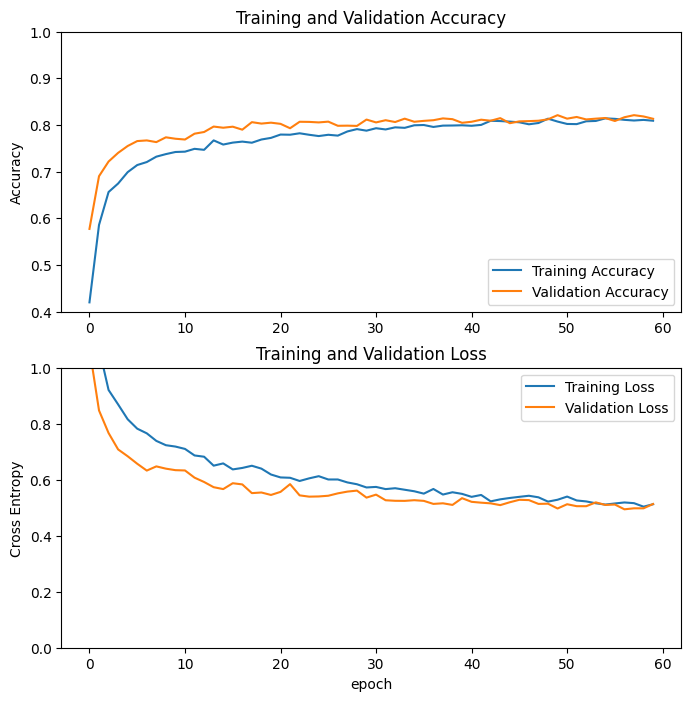

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [75]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 160
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=['accuracy']
    )
model.summary()
len(model.trainable_variables)

Number of layers in the base model:  176
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_21 (Dense)            (None, 128)               262272    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 6)                 390       
                                                                 
Total params: 23,858,630
Trainable params: 5,791,302
Non-trainable params: 18,067,328
___________________________________________________________

22

In [ ]:
history_fine_tuning = model.fit(
    train_data,
    validation_data=val_data,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1],
)

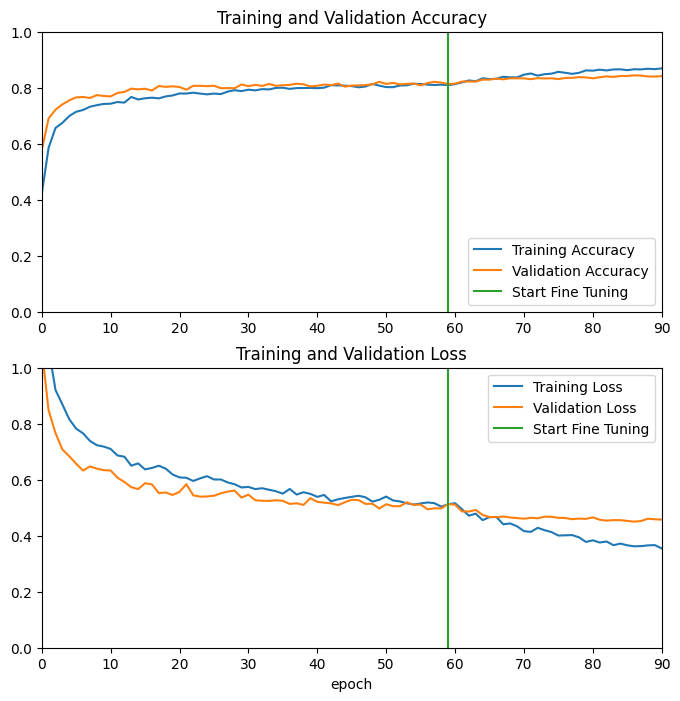

In [77]:
acc += history_fine_tuning.history['accuracy']
val_acc += history_fine_tuning.history['val_accuracy']
loss += history_fine_tuning.history['loss']
val_loss += history_fine_tuning.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.xlim([0, initial_epochs + fine_tune_epochs])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.xlim([0, initial_epochs + fine_tune_epochs])
plt.show()

### Gerar previsões

In [ ]:
...